# Preparation

## Load datasets

## Import packages

In [1]:
from src.utils import read_gtf, collapse_isoforms_to_proteoforms
import polars as pl
from scipy import sparse
import numpy as np

In [2]:
from SingleCell.single_cell import SingleCell
from SingleCell.utils import print_df
from SingleCell.ryp import r, to_r, to_py

In [3]:
r(
"""
library(ggplot2)
library(dplyr)
library(tidyr)
library(svglite)

source("SingleCell/ggplot_theme.R")
"""
)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
final_classification = pl.read_parquet("nextflow_results/V47/final_classification.parquet")
final_expression = pl.read_parquet("nextflow_results/V47/final_expression.parquet")
orfanage_gtf = read_gtf("nextflow_results/V47/orfanage/orfanage.gtf")
annot_peptides_hybrid = read_gtf("nextflow_results/V47/orfanage/annot_peptides_hybrid.gtf", attributes=["gene_name", "transcript_id", "novelty", "detected"])
peptide_mapping = pl.read_parquet("nextflow_results/V47/orfanage/peptide_mapping.parquet")
protein_classification = pl.read_csv("nextflow_results/V47/orfanage/SFARI.protein_classification.tsv", separator="\t")

In [39]:
final_expression_with_category = (
    final_expression
    .join(
        final_classification.select(["isoform", "structural_category"]),
        on="isoform",
        how="left"
    )
    .with_columns(pl.sum_horizontal(pl.selectors.numeric()).alias("total_expression"))
)

# Figure 1

In [13]:
print(f"We define {final_classification.shape[0]} unique mRNA isoforms across {final_classification["associated_gene"].n_unique()} genes, with a median length of {final_classification["length"].median()} nt.")

We define 182371 unique mRNA isoforms across 20442 genes, with a median length of 2577.0 nt.


In [6]:
print("These are the structural categories defined in SQANTI:")
final_classification["structural_category"].unique()

These are the structural categories defined in SQANTI:


structural_category
str
"""genic"""
"""novel_not_in_catalog"""
"""incomplete-splice_match"""
"""antisense"""
"""intergenic"""
"""novel_in_catalog"""
"""full-splice_match"""
"""moreJunctions"""
"""fusion"""


In [24]:
novel_classification = final_classification.filter(pl.col("structural_category").is_in(["novel_in_catalog", "novel_not_in_catalog", "incomplete-splice_match"]))

In [25]:
print("We define FSM transcripts as known and ISM, NIC, and NNC transcripts as novel.")
print(f"Therefore, there are {novel_classification.shape[0]} novel transcripts in the final classification")

We define FSM transcripts as known and ISM, NIC, and NNC transcripts as novel.
Therefore, there are 108377 novel transcripts in the final classification


In [41]:
novel_expression_with_category = (
    final_expression_with_category
    .filter(pl.col("structural_category").is_in(["novel_in_catalog", "novel_not_in_catalog", "incomplete-splice_match"]))
)

def compute_pct_above_threshold(df: pl.DataFrame, n_min: int) -> float:
    total_rows = df.height
    gt_rows = df.filter(pl.col("total_expression") > n_min).height
    pct = (gt_rows / total_rows) * 100
    return pct

print(f"""
Notably, over half of the detected transcripts ({novel_expression_with_category.shape[0]/final_expression.shape[0]*100:.1f}%, {novel_expression_with_category.shape[0]} total) were classified as novel (Fig. 1E), revealing a vast landscape of unannotated splicing.
While these novel isoforms generally showed lower expression than known isoforms, the majority were well-supported with {compute_pct_above_threshold(novel_expression_with_category, 100):.1f}% and {compute_pct_above_threshold(novel_expression_with_category, 500):.1f}% of novel transcripts having >100 and >500 reads
""")



Notably, over half of the detected transcripts (59.4%, 108377 total) were classified as novel (Fig. 1E), revealing a vast landscape of unannotated splicing.
While these novel isoforms generally showed lower expression than known isoforms, the majority were well-supported with 51.7% and 14.3% of novel transcripts having >100 and >500 reads



In [44]:
r("novel_expression")

    [1]     229      60    8680     211    2036     294      89      62     168
   [10]      33      43     106     234      61    1196     126     159      42
   [19]      40      46     293     100     106     506    1460      87     106
   [28]      49     237     100     277     263      56      59     171      83
   [37]     572      84    2831      60      82      59     475      91      72
   [46]      71     290     140      29      83     122      38    2820      73
   [55]     393      37      50     657     134      62      56     419    2188
   [64]     153      65     191     100    1279      83      63     260      63
   [73]     107      72      87     135      67      48     119      83      42
   [82]      57     158     107     102     290     110     188      43     499
   [91]     334     383      52      36      51     231      47      93     190
  [100]     379      68      49      83      51     538      97     168      79
  [109]     136      89    1445      40 

In [43]:
to_r(final_expression_with_category, "final_expression_r")

r(
"""
novel_expression = final_expression_r %>%
    filter(structural_category %in% c("novel_in_catalog", "novel_not_in_catalog", "incomplete-splice_match")) %>%
    pull(total_expression)
known_expression = final_expression_r %>%
    filter(structural_category == "full-splice_match") %>%
    pull(total_expression)
t_test_result = t.test(novel_expression, known_expression)
t_test_result
"""
)


	Welch Two Sample t-test

data:  novel_expression and known_expression
t = -17.54, df = 69757, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4725.142 -3775.252
sample estimates:
mean of x mean of y 
 678.9903 4929.1875 



# Figure 2

In [ ]:
print(f"There are {orfanage_gtf.filter(pl.col("feature")=="transcript").unique("transcript_id").shape[0]} transcripts that contain CDS predicted by ORFanage")

There are 162913 transcripts that contain CDS predicted by ORFanage


In [6]:
pb = flnc\
    .with_uns(QCed=True)\
    .pseudobulk(ID_column="sample_name", cell_type_column="cell_type")

In [18]:
pl.concat(
    [
        flnc.select_var("isoform", "structural_category").var,
        pl.DataFrame({cell_type: pb.log_CPM().X[cell_type].mean(axis=0) for cell_type in pb.log_CPM().X.keys()}).mean_horizontal().to_frame()
    ],
    how = "horizontal"
)\
.pipe(to_r, "log_CPM_per_cell_type")

null device 
          1 


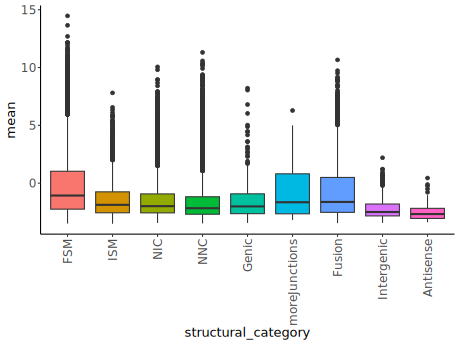

In [21]:
r(
"""
log_CPM_per_cell_type %>% 
    select(isoform, structural_category, mean) %>% 
    mutate(
        structural_category = structural_category_labels[structural_category]
    ) %>%
    mutate(
        structural_category = factor(structural_category, levels = c("FSM", "ISM", "NIC", "NNC", "Genic", "moreJunctions", "Fusion", "Intergenic", "Antisense"))
    ) %>% 
    ggplot(
        aes(x = structural_category, y = mean, fill = structural_category)
    ) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
"""
)

In [10]:
isoforms_to_proteoforms = collapse_isoforms_to_proteoforms(orfanage_gtf)

In [11]:
f"There are {isoforms_to_proteoforms.unique("base_isoform").shape[0]} unique ORFs."

'There are 81745 unique ORFs.'

In [22]:
n_novel_protein_isoform = protein_classification\
    .join(
        isoforms_to_proteoforms.rename({"isoform": "pb"}),
        on = "pb",
        how = "left"
    ).unique("base_isoform")\
    .filter(pl.col("protein_classification_base").is_in(["pNIC", "pNNC"]))\
    .shape[0]
print(f"There are {n_novel_protein_isoform} novel protein isoforms")

There are 57489 novel protein isoforms


In [ ]:
n_novel_peptides = annot_peptides_hybrid\
    .filter(
        pl.col("detected")=="True",
        pl.col("novelty")=="novel"
    )\
    .unique("transcript_id")\
    .shape[0]

novel_peptides = annot_peptides_hybrid\
    .filter(
        pl.col("detected")=="True",
        pl.col("novelty")=="novel"
    )\
    .unique("transcript_id")\
    ["transcript_id"]

print(f"There are {n_novel_peptides} novel peptides that have been detected.")

There are 160 novel peptides that have been detected.


In [24]:
n_transcripts = peptide_mapping\
    .filter(
        pl.col("peptide").is_in(novel_peptides)
    ).unique("pb").shape[0]

novel_transcripts_validated = peptide_mapping\
    .filter(
        pl.col("peptide").is_in(novel_peptides)
    ).unique("pb")["pb"]

print(f"{n_transcripts} transcripts have been validated by these novel peptides.")

440 transcripts have been validated by these novel peptides.


In [29]:
n_genes = final_classification\
    .filter(
        pl.col("isoform").is_in(novel_transcripts_validated)
    ).unique("associated_gene").unique("associated_gene").shape[0]

print(f"There are {n_genes} genes that these transcripts map to.")


There are 151 that these transcripts map to.


## Transcripts in novel genes

In [17]:
novel_genes = final_classification\
    .filter(
        pl.col("associated_gene").str.starts_with("novel")
    )
print(f"These are the structural categories of the transcripts in novel genes: {novel_genes['structural_category'].unique().to_list()}")

These are the structural categories of the transcripts in novel genes: ['antisense', 'intergenic']


In [18]:
print(f"{novel_genes.shape[0] / final_classification.shape[0] * 100:.2f}% ({novel_genes.shape[0]}) of the identified isoforms are in novel genes, which is in {novel_genes.unique("associated_gene").shape[0]} genes.")
novel_genes\
    .group_by("structural_category")\
    .len()

0.39% (712) of the identified isoforms are in novel genes, which is in 632 genes.


structural_category,len
str,u32
"""antisense""",267
"""intergenic""",445


## Gene fusion transcripts

In [ ]:
n_fusion = final_classification\
    .filter(
        pl.col("structural_category") == "fusion"
    ).shape[0]
print(f"There are {n_fusion} fusion transcripts in the final classification")

There are 4332 fusion transcripts in the final classification


# FLNC reads

In [9]:
import json
from pathlib import Path

def get_num_reads_flnc_poly(path_to_json):
    with open(path_to_json, 'r') as file:
        data = json.load(file)
    return [d for d in data["attributes"] if d.get('id') == "isoseq_primers.num_reads_flnc_polya"][0]['value']
num_reads_flnc_polya_dict = {str(Path(json_path)).split("/")[-3].replace("_150PM_CELL1", ""): get_num_reads_flnc_poly(json_path) for json_path in Path(".").glob("data/long_read/LUO26876.20240514/*/outputs/isoseq_primers.report.json")}
num_reads_flnc_polya = pl.DataFrame(num_reads_flnc_polya_dict).transpose(include_header=True,header_name="sample_name").rename({"column_0": "num_reads_flnc_polya"})

Here is the number of polyA flnc reads per sample:

In [10]:
num_reads_flnc_polya

sample_name,num_reads_flnc_polya
str,i64
"""NPC_1_1""",44046834
"""NPC_3_1""",42743264
"""CN_2_2""",47669930
"""iPSC_1""",53016997
"""iPSC_2""",43145976
…,…
"""NPC_2_1""",38409411
"""CN_2_1""",49770715
"""NPC_3_3""",50287679


In [14]:
print(f"The average number of polyA flnc reads is {num_reads_flnc_polya["num_reads_flnc_polya"].mean()/1000000} million")

The average number of polyA flnc reads is 45.93263 million


In [13]:
print(f"The total number of polyA flnc reads is {num_reads_flnc_polya["num_reads_flnc_polya"].sum()/1000000} million")

The total number of polyA flnc reads is 688.98945 million


# Splice site conservation

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
ORFanage_ss = pl.read_csv("export/ORFanage_splice_sites.csv")
classification = pl.read_parquet("nextflow_results/V47/final_classification.parquet")

(0.0, 60000.0)

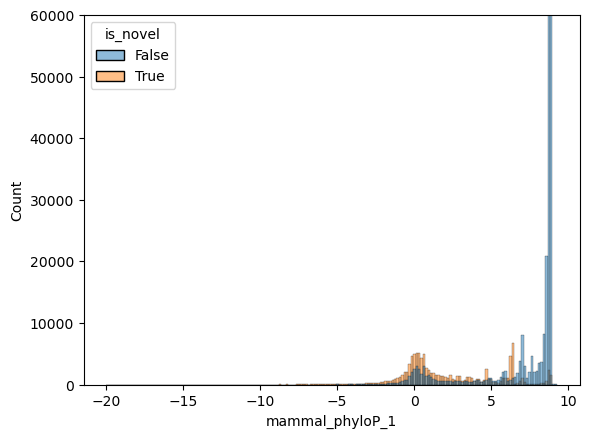

In [11]:
ORFanage_ss\
    .pipe(sns.histplot, x="mammal_phyloP_1", hue="is_novel")
plt.ylim(0, 60000)

In [31]:
novel_ss = ORFanage_ss\
    .filter(
        pl.col("is_novel"),
        pl.col("mammal_phyloP_1") > 5
    )\
    .with_columns(
        start = pl.when(pl.col("start_or_end")=="start")\
            .then(pl.col("coord"))\
            .when(pl.col("start_or_end")=="end")\
            .then(pl.col("coord") - 1),
        end = pl.when(pl.col("start_or_end")=="start")\
            .then(pl.col("coord") + 1)\
            .when(pl.col("start_or_end")=="end")\
            .then(pl.col("coord"))
    )

In [36]:
novel_ss

chrom,strand,start_or_end,coord,transcript_id,is_CDS,canonical,SR,is_novel,mammal_phyloP_1,mammal_phyloP_2,start,end
str,str,str,i64,str,bool,bool,bool,bool,f64,f64,i64,i64
"""chr14""","""-""","""end""",60975111,"""PB.86550.56""",true,false,false,true,6.313,1.417,60975110,60975111
"""chr1""","""-""","""start""",43360077,"""PB.1515.20""",true,true,false,true,8.67,-1.055,43360077,43360078
"""chr6""","""+""","""start""",170572263,"""PB.48037.1""",true,false,false,true,6.36,3.725,170572263,170572264
"""chr14""","""-""","""end""",87949910,"""PB.87656.35""",false,true,true,true,5.73,4.732,87949909,87949910
"""chr16""","""+""","""start""",69083659,"""PB.93652.219""",true,false,false,true,6.335,4.712,69083659,69083660
…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr16""","""-""","""start""",31135499,"""PB.92659.23""",true,false,false,true,5.84,2.348,31135499,31135500
"""chr3""","""-""","""end""",15573208,"""PB.19087.283""",false,false,false,true,6.328,-0.8,15573207,15573208
"""chr13""","""-""","""end""",52844562,"""PB.81786.16""",true,false,false,true,6.328,6.354,52844561,52844562


In [35]:
novel_ss.write_csv("export/ORFanage_novel_splice_sites.csv")

In [28]:
novel_ss\
    .join(
        classification.rename({"isoform": "transcript_id"})["transcript_id", "associated_gene"],
        on="transcript_id",
        how="left" 
    ).unique("associated_gene")

chrom,strand,start_or_end,coord,transcript_id,is_CDS,canonical,SR,is_novel,mammal_phyloP_1,mammal_phyloP_2,associated_gene
str,str,str,i64,str,bool,bool,bool,bool,f64,f64,str
"""chr6""","""+""","""end""",33456238,"""PB.42600.237""",false,true,false,true,8.787,-3.308,"""ZBTB9"""
"""chr4""","""+""","""start""",88061946,"""PB.29273.10""",false,false,false,true,5.69,0.205,"""PKD2"""
"""chr3""","""-""","""start""",124859279,"""PB.23302.19""",true,true,false,true,6.699,6.042,"""ITGB5"""
"""chr16""","""-""","""start""",4115443,"""PB.91715.1220""",false,false,false,true,8.671,3.626,"""ADCY9"""
"""chr14""","""+""","""start""",85623495,"""PB.87517.427""",true,false,false,true,6.36,6.052,"""FLRT2"""
…,…,…,…,…,…,…,…,…,…,…,…
"""chr9""","""-""","""end""",35111566,"""PB.61351.170""",true,true,true,true,8.54,6.087,"""ATOSB"""
"""chr7""","""+""","""start""",107758707,"""PB.51923.26""",false,false,false,true,5.73,5.798,"""CBLL1"""
"""chr6""","""-""","""end""",33697655,"""PB.42608.23""",true,false,false,true,6.335,3.651,"""UQCC2"""


In [29]:
to_r(novel_ss, "novel_ss")

In [34]:
r(
"""
library(readxl)
library(dplyr)
library(GenomicRanges)
library(GenomicFeatures)

de_novo_variants <- read_excel("data/mmc2.xlsx", sheet="Table S2C", skip=1)

de_novo_variants <- de_novo_variants %>% 
    separate(
        col   = Variant,
        into  = c("chr", "pos", "ref", "alt"),
        sep   = ":",
        convert = TRUE
    ) %>% 
        filter(!grepl("_", chr)) %>%
        mutate(
            chr = paste0("chr", chr)
    ) %>% 
        filter(nchar(ref) == 1)

de_novo_variants_gr <- GRanges(
    seqnames = de_novo_variants$chr,
    ranges   = IRanges(start = de_novo_variants$pos, end = de_novo_variants$pos),
    strand   = "*"
)

novel_ss <- GRanges(
    seqnames = novel_ss$chrom,
    ranges   = IRanges(start = novel_ss$start, end = novel_ss$end),
    strand   = "*"
)

de_novo_variants_in_novel_ss <- de_novo_variants[queryHits(findOverlaps(de_novo_variants_gr, novel_ss)), ] %>% 
    distinct(chr, pos, ref, alt, .keep_all = TRUE)
"""
)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



RuntimeError: in library(GenomicRanges) : 
  there is no package called ‘GenomicRanges’
Calls: withAutoprint -> source -> withVisible -> eval -> eval -> library

In [18]:
de_novo_variants = to_py("de_novo_variants")

In [19]:
de_novo_variants

index,Variant,Child ID,Mother ID,Father ID,ASD status,Gene,pLI,Variant type,MPC,Dataset
i32,str,str,str,str,f64,str,str,str,str,str
1,"""1:93584017:C:A""","""13069.s1""","""13069.mo""","""13069.fa""",1.0,"""BCAR3""","""0.91677985497583803""","""splice_donor_variant""","""NA""","""ASC"""
2,"""10:113151124:G:A""","""35906""","""35902""","""35900""",2.0,"""TCF7L2""","""0.98960502908944004""","""splice_donor_variant""","""NA""","""ASC"""
3,"""12:115980748:A:AC""","""SSC05997""","""SSC06001""","""SSC06008""",2.0,"""MED13L""","""0.99999999867714695""","""splice_donor_variant""","""NA""","""ASC"""
4,"""9:14150144:C:T""","""36153""","""36149""","""36147""",2.0,"""NFIB""","""0.99080916701878896""","""splice_donor_variant""","""NA""","""ASC"""
5,"""11:66487343:G:A""","""AU190A""","""AU190C""","""AU190B""",2.0,"""DPP3""","""4.3633209033058898E-9""","""splice_donor_variant""","""NA""","""ASC"""
…,…,…,…,…,…,…,…,…,…,…
167756,"""18:6030026:C:T""","""SP0253839""","""SP0254149""","""SP0253897""",2.0,"""L3MBTL4""","""4.2000437757347599E-8""","""other""","""NA""","""SPARK_WES_2"""
167757,"""2:127636516:A:C""","""SP0254040""","""SP0254038""","""SP0254059""",2.0,"""MYO7B""","""6.3829496749846E-16""","""other""","""NA""","""SPARK_WES_2"""
167758,"""2:127636519:A:C""","""SP0254040""","""SP0254038""","""SP0254059""",2.0,"""MYO7B""","""6.3829496749846E-16""","""other""","""NA""","""SPARK_WES_2"""
